# Imports

In [1]:
import os

import numpy as np
import pandas as pd

# Commented out because Modin is not compatible with Lux.
# import modin.pandas as pd
# from distributed import Client
# client = Client() # Initialize for Dask, which is used by modin.

import lux

# The `display` function is what is used behind the scenes to format raw data for display in a notebook.
from IPython.display import display, Markdown

# Needed if I want fine-grained access to modify plots.
import matplotlib.pyplot as plt

# Data Set Description

For a formatted version of the data set description from the [source website](https://archive.ics.uci.edu/ml/datasets/Bank+Marketing), see [Data Set Description.md](Data Set Description.md).

# Data import and cleaning

Boilerplate to read in the data and display its list of columns.

In [45]:
data_path = 'bank-additional/bank-additional-full.csv'
if not os.path.exists(data_path):
    print(f'ERROR: Cannot find file {data_path}')

df = pd.read_csv(data_path, sep=';')

## Inspect & Rename columns/fields

What data type did each column come in as?

In [3]:
df.dtypes

age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object


Let's give some of these columns better names.
 * The outcome variable is called "y", which is meaningless. Let's call it "output".
 * Likewise, the column named "default" reports whether the person has any credit in default.
 * Both "housing" and "loan" refer to a loan, housing loan and personal loan respectively. 
 * Let's indicate which columns are associated with contact during the current campaign and which with the previous campaign.
 * The "campaign" column reports how many times the person was contacted for this current campaign.
 * etc.

In [46]:
df.rename(
    inplace=True, 
    columns={
        # Customer info
        'y':'outcome', 
        'default': 'credit_in_default', 
        'housing': 'housing_loan', 
        'loan':    'personal_loan', 
        
        # Specific to this campaign
        'contact':     'contact_method',
        'month':       'contact_month',
        'day_of_week': 'contact_weekday',
        'duration':    'contact_duration', # Do not use for prediction. See data description.
        'campaign':    'contact_count',    # For this campaign only
        # Regarding previous campaign
        'pdays':       'days_since_previous_campaign_contact',
        'previous':    'previous_contact_count', # Count of times contacted before the current campaign.
        'poutcome':    'previous_outcome',       # Outcome of previous campaign.
        
        # Social and Economic data
        'emp.var.rate':   'employment_variation_rate', # Quarterly indicator -- for what quarter?
        'cons.price.idx': 'consumer_price_index',      # Monthly indicator -- for what month?
        'cons.conf.idx': 'consumer_confidence_index',  # Monthly indicator -- for what month?
        'euribor3m':     'euribor_3_month_rate',       # Daily indicator -- for what day?
        'nr.employed':   'employee_count',             # What is this?
    }
)

## Inspect values to understand data set

### Are there any missing values?

Several columns have a special value that is semantically equivalent to `NaN`/`Null`, but do any of the columns in any of the rows actually contain `NaN`/`Null`?

In [5]:
len(df[df.isnull().any(axis=1)])

0

No `NaN`/`Null` values. In some cases, having `NaN`/`Null` values is convenient for the purposes of encoding. We will convert the semantically equivalent special values to `NaN`.

In [6]:
replacements = {
    # Several columns
    'unknown': np.nan,
    # Days since previous campaign contact uses 999 as a special value
    999: np.nan,
    # If a customer did not exist during the previous campaing, its outcome is `'nonexistent'`
    'nonexistent': np.nan,
}
df.replace(to_replace=replacements, inplace=True)

### What are "Social and Economic Context Attributes"?

Let's inspect the "Social and Economic Context Attributes" data. For each column, we display each value and a count of how many times that value appears in the data set.

In [7]:
for col in ['employment_variation_rate', 'consumer_price_index','consumer_confidence_index', 'euribor_3_month_rate', 'employee_count']:
    display(df[col].value_counts())

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

It is still not clear which quarter/month/day the economic indicators refer to. It may be the time period associated to the date of last contact for the current campaign. Likewise, it is not clear what "number of employees" means, particularly considering most of the values are not whole numbers. Without knowing more, it is hard to interpret these columns. However, we can still use them as features as long as we are careful regarding the assumptions we make of them.

### Education

Education could be an ordered education *level*. A reasonable guess of order from least education to most education might be

0. illiterate
1. basic.4y
2. basic.6y
3. basic.9y
4. high.school
5. professional.course
6. university.degree

with "unknown" being treated as a missing value. We assume this ordering and encode it in a new column named "education_level". It is not clear, though, if "professional.course" is comparable to the others.

In [8]:
ed_levels = {
    'illiterate': 0,
    'basic.4y': 1,
    'basic.6y': 2,
    'basic.9y': 3,
    'high.school': 4,
    'professional.course': 5,
    'university.degree': 6,
    'unknown': np.nan,
    # If I have already replaced `'unknown'` with `np.nan`:
    np.nan: np.nan
}
df['education_level'] = df['education'].map(lambda x: ed_levels[x])

### Values in other columns

Let's inspect what values appear in some of the other columns. As before, we can find counts for each unique value in a column `col` by executing `display(df[col].value_counts())`. For quantitative columns, for economy of space we will look at a histogram and refer to the value counts without explicitly computing them. The Lux plugin for Jupyter can do this automatically for us.

In [9]:
df[['age', 'job', 'marital', 'education', 'credit_in_default',
       'housing_loan', 'personal_loan', 'contact_method', 'contact_month',
       'contact_weekday', 'contact_duration', 'contact_count',
       'days_since_previous_campaign_contact', 'previous_contact_count',
       'previous_outcome']]

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

The following will display value counts for the listed columns, but we hide the output for economy of space.

In [10]:
for col in ['age', 'job', 'marital', 'education', 'credit_in_default',
       'housing_loan', 'personal_loan', 'contact_method', 'contact_month',
       'contact_weekday', 'contact_duration', 'contact_count',
       'days_since_previous_campaign_contact', 'previous_contact_count',
       'previous_outcome']:
    display(df[col].value_counts())

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

Button(description='Toggle Pandas/Lux', layout=Layout(top='5px', width='140px'), style=ButtonStyle())

Output()

We find almost all customers were never contacted for the previous campaign. Likewise, relatively few customers have data for the outcome of the previous campaign (perhaps because they were not customers at the time). This casts doubt on the usefulness of these fields except as a comparative benchmark.

Only 3 records have a value of yes in the "credit_in_default" column. (The remaining values are either no or unknown.) Because any "correlation" within the 3 yes records has a high likelihood of being due to random chance, this column should not be used for prediction. 

## Panel Data (Time Series)

The campaign ran from March through December. The contact month is the month of the last contact of the campaign, allowing us to view the data set as panel data (multidimensional equivalent of time series). We transform each month to its usual numeric value to more easily order the data by time.

The task is to predict the outcome using the data set, but in practice we would probably want to update the model *during* a campaign. The months column would be crucial for developing that model.

In [12]:
months = { m: i+3 for i, m in enumerate(['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']) }
df['contact_month'] = df['contact_month'].map(lambda x: months[x])

Let's see a histogram.

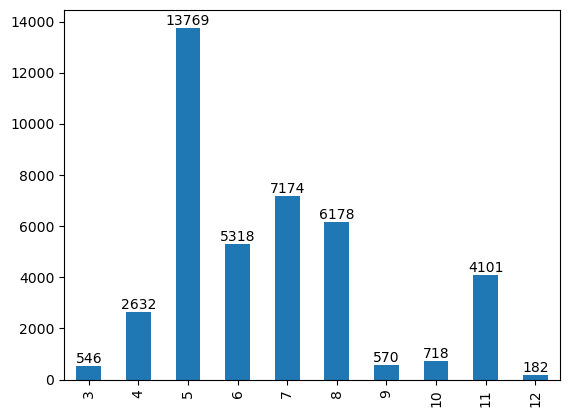

In [13]:
month_hist_data = df['contact_month'].value_counts().sort_index()
ax = month_hist_data.plot.bar()
_  = ax.bar_label(ax.containers[0])
plt.show()

# Predictive Models

## Measuring Performance

There are many ways to measure the performance of a predictive model. The problem context—the businesss use-case, computational environment, etc.— will determine which metrics are most suitable for judging the suitability of a model. In the case of this problem, let us assume that we wish to target only those customers who the model predicts will ultimately subscribe to the product. Our goal, then, is to simultaneously

1. minimize the number of customers the campaign targets, which has a theoretical minimum equal to the true number of subscribers; and
1. maximize the number of customers who ultimately choose to subscribe to the product, which has a theoretical maximum equal to the true number of subscribers.

A priori, it may not be possible to achieve both goals simultaneously without an infallible oracle. Consider the extreme cases: One way to achieve the second goal is to target every customer. Then every customer that will respond to the campaign with a subscription is sure to be targeted, and thus the number of subscribers is maximized. However, the number of targeted customers is also maximized. Likewise, the second goal is achievable by not targeting any customer, but this strategy *minimizes* the number of customers who will ultimately subscribe to the product.

In the presence of some fixed uncertainty, the optimal strategy will ultimately depend on the marginal cost of targeting a customer relative to the marginal reward of obtaining an additional subscriber. Let's call this the *secondary* optimization problem. These costs are not provided in the problem statement, so we must assume that this secondary optimization problem will be solved after we develope our predictive model, perhaps by a different business unit that better understand those business costs. Our goal, then, is to try to control the uncertainty, as it is clear that a model which more accurately predicts the true outcome than another model is strictly superior to that other model *regardless of the secondary optimization problem.*

Let us adopt the following abbreviations:

|  |  |  The model… |
|:---|:---|:---|
| TP | True Positive | correctly predicts a customer will subscribe |
| TN | True Negative | correctly predicts a customer will not subscribe |
| FP | False Positive | incorrectly predicts a customer will subscribe |
| FN | False Negative | incorrectly predicts a customer will not subscribe |

![Abbreviations](./Prediction.svg)


Given the discussion above and a little reflection, it is clear that we wish to

1. maximize TP, and
1. maximize TN.

(Since any one of the sets can be written in terms of the others, there are multiple equivalent ways of expressing this. For example: We want to minimize FP and minimize FN.) We will use the following metrics to quantify how well these goals are achieved (see [wikipedia](https://en.wikipedia.org/wiki/Sensitivity_and_specificity#Specificity) for these metrics and others):

| Term and Common Synonyms | &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Formula&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; | Interpretation |
|:------|:--------:|:-------|
| sensitivity,<br>recall,<br>hit rate,<br>or true positive rate (TPR) | ${\frac {\mathrm {TP} }{\mathrm {P} }}={\frac {\mathrm {TP} }{\mathrm {TP} +\mathrm {FN} }}$ | The percentage of subscribers that were accurately predicted |
| specificity,<br>selectivity or<br>true negative rate (TNR) | ${\frac {\mathrm {TN} }{\mathrm {N} }}={\frac {\mathrm {TN} }{\mathrm {TN} +\mathrm {FP} }}$ | The percentage of nonsubscribers that were accurately predicted |

We will also give TN, TP, FN, and FP in absolute numbers in the form of the matrix:

|  | Actual Subscriber | Actual Nonsubscriber | Total |
|-----:|:---:|:----:|:----|
| Predicted Subscriber | TP | FP | TP + FP |
| Predicted Nonsubscriber | FN | TN | FN + TN |
| Total | TP + FN | FP + TN | \# of People |

The four central cells of this matrix is called the confusion matrix. 

Classification models often have a threshold parameter that controls the cutoff probability above which a prediction is determined to be positive (predicted yes). For consistency we keep this value at 50%, but in practice the marginal cost of a false positive relative to marginal cost of targeting a customer will determine how to tune this parameter. 

Models are trained on 75% of the data set and their performance is evaluated on the remaining 25%.

#### Code to compute performance

In [14]:
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix

In [15]:
def confusion_matrix_md(predicted_y, true_y):
    tn, fp, fn, tp = confusion_matrix(y_pred=predicted_y, y_true=true_y).ravel()
    display(Markdown( f"""|  | Actual Subscriber | Actual Nonsubscriber | Total |
|-----:|:---:|:----:|:----|
| Predicted Subscriber | TP = {tp} | FP = {fp} | TP + FP = {tp+fp} |
| Predicted Nonsubscriber | FN = {fn} | TN = {tn} | FN + TN = {fn+tn} |
| Total | TP + FN={tp+fn} | FP + TN = {fp+tn} | {tp+tn+fp+fn} |"""))
    

In [16]:
def recall_selectivity_md(predicted_y, true_y):
    tn, fp, fn, tp = confusion_matrix(y_pred=predicted_y, y_true=true_y).ravel()
    display(Markdown( f"""|  | &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|
|-----:|:---|
| Recall | ${{ {{\mathrm {{TP}} }} \over {{\mathrm {{TP}} +\mathrm {{FN}} }}}}=$ {tp/(tp+fn):.2%} |
| Selectivity | ${{ {{\mathrm {{TN}} }} \over {{\mathrm {{TN}} +\mathrm {{FP}} }}}}=$ {tn/(tn+fp):.2%} |"""))

## Linear Regression Model

### Pros and Cons of Linear Regression

A linear regression model assumes the probability of the outcome conditioned on concrete values for the explanatory variables is a linear combination of those values. Of course, linear models work best when the relationships between the explanatory variables and the outcome are linear relationships, that is, they are linearly correlated.

It is possible for two variables to have a very strong nonlinear relationship. Purely linear analysis can obscure this relationship, a phenomenon famously illustrated by [Anscombe's quartet](https://en.wikipedia.org/wiki/Anscombe%27s_quartet), which consists of four data sets "that have nearly identical simple descriptive statistics, yet have very different distributions":

![Anscombe's quartet](https://upload.wikimedia.org/wikipedia/commons/e/ec/Anscombe%27s_quartet_3.svg)


A model that assumes only linear relationships may perform very poorly despite the existence of a strong nonlinear relationships. Another challenge is multicolinearity, which is the phenomenon that the explanatory variables are not linearly independent. 

A full exposition of the assumptions of linear regression and the consequences of violations of those assumptions is out of scope of this exercise. However, linear relationships are abundant in nature, and in contexts in which linear regression performs well, it has the additional advantage of being easy to understand relative to other methods.

For the reasons discussed above, ***we should expect this model to perform poorly*** relative to other models. However, it is so easy to understand and apply that it is worth trying nonetheless. It also gives us a basis for comparison for other models.

### Encoding categorical variables

When the data set contains categorical data that we want to use in linear regression, we have to give the categorical variables a numerical encoding. In fact, we have already done so for the month and education columns, which have a natural encoding as nonnegative integers. In the case of education, we must decide how to handle missing values, which occurs in ~4% of records. For now, we just omit those records from the model. Because our goal is to determine the most efficient allocation of the bank's resources, and because only ~4% of records omit education, this is a sensible choice.

For other columns like the "marital" and the ""\*\_loan" columns we will use dummy coding, which introduces new variables the possible values, where the new variables can take the values 0 or 1. If a value is required for the original field (no "missing" or "unknown" values), then we keep one of the values implicit. It will be represented by having a 0 in every one of the new binary variables. 

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [19]:
# Probably don't need this list, but we keep it to make the excluded columns explicit.
excluded_columns = [
    # Too few records have credit in default
    'credit_in_default', 
    # Data for previous campaign is mostly missing, so we use it only for benchmark comparisons
    'days_since_previous_campaign_contact', 'previous_contact_count', 'previous_outcome',
    # Encoded as `'education_level'`
    'education',
    # Excluded; see note in data set description.
    'contact_duration',
    # Variable we wish to predict
    'outcome', 
]

# Columns to use as predictors for linear regression.
lr_columns = ['age', 'job', 'marital', 'housing_loan', 'personal_loan', 'contact_method', 'contact_month', 'contact_weekday',  'contact_count',  'employment_variation_rate', 'consumer_price_index', 'consumer_confidence_index', 'euribor_3_month_rate', 'employee_count', 'education_level']

df_lr = df[lr_columns][df['education'].notnull()]
df_lr_outcome = df['outcome'][df['education'].notnull()]

For columns in which missing data is represented by `np.nan`, the NaN value will become implicit in the simple dummy encoding (`drop_first=false`, `dummy_na=True`). In other columns, we arbitrarily choose the first value to be implicit (`drop_first = True`, `dummy_na=False`).

In [23]:
# First value is implicit
encoded_cols = ['contact_method', 'contact_weekday']
df_dummies = pd.get_dummies(df_lr[encoded_cols], drop_first = True, dummy_na=False)

df_lr = pd.concat([df_lr[[c for c in df_lr.columns if c not in encoded_cols]], df_dummies], axis=1)

# NaN value is implicit
encoded_cols = ['marital', 'job', 'housing_loan', 'personal_loan']
df_dummies = pd.get_dummies(df_lr[encoded_cols], drop_first = False, dummy_na=True)

df_lr = pd.concat([df_lr[[c for c in df_lr.columns if c not in encoded_cols]], df_dummies], axis=1)

As NaN values will be implicit, we drop the encoded NaN columns.

In [24]:
df_lr = df_lr[[c for c in df_lr.columns if not c.endswith('_nan')]]

Finally, the outcome has values of 'yes' and 'no', which we encode as 1 and 0 respectively.

In [25]:
convert = {'no': 0, 'yes': 1}
df_lr_outcome = df_lr_outcome.map(convert)

### Training the LR Model

In [26]:
df_lr_train, df_lr_test, df_lr_outcome_train, df_lr_outcome_test = train_test_split(df_lr, df_lr_outcome, test_size=0.25, random_state=42)

In [27]:
lr_model = LinearRegression()
lr_model.fit(df_lr_train, df_lr_outcome_train)

LinearRegression()

### Evaluating the Performance of the LR Model

In the following we evaluate the performance of the LR model on the test set.

> The coefficient of determination $R^2$ is defined as $R^2 = (1 - \frac{u}{v})$, where is the residual sum of squares `((y_true - y_pred)** 2).sum()` and is the total sum of squares `((y_true - y_true.mean()) ** 2).sum()`.

The `score()` function computes $R^2$:

In [28]:
lr_model.score(df_lr_test, df_lr_outcome_test)

0.16641426355941735

We transform the real-valued response variable into a 'yes'/'no' response (encoded as 1 and 0 as before):

In [29]:
lr_predicted = np.round(lr_model.predict(df_lr_test)).astype(int)

In [30]:
lr_performance = pd.DataFrame(data={'predicted': lr_predicted, 'outcome': df_lr_outcome_test})

We compute the confusion matrix and performance metrics.

In [31]:
confusion_matrix_md(lr_predicted, df_lr_outcome_test)
recall_selectivity_md(lr_predicted, df_lr_outcome_test)

|  | Actual Subscriber | Actual Nonsubscriber | Total |
|-----:|:---:|:----:|:----|
| Predicted Subscriber | TP = 151 | FP = 112 | TP + FP = 263 |
| Predicted Nonsubscriber | FN = 957 | TN = 8645 | FN + TN = 9602 |
| Total | TP + FN=1108 | FP + TN = 8757 | 9865 |

|  | &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|
|-----:|:---|
| Recall | ${ {\mathrm {TP} } \over {\mathrm {TP} +\mathrm {FN} }}=$ 13.63% |
| Selectivity | ${ {\mathrm {TN} } \over {\mathrm {TN} +\mathrm {FP} }}=$ 98.72% |

From the matrix we can see that while we only targeted 263/9865 = 2.66% of the customers, we were able to capture 151/1108 = 13.63% of the theoretical maximum number of subscribers. Whether or not this trade-off is worth it cannot be determined, but a recall of only 13.63% is not particularly impressive.

## Random Forest Classifier

A random forest classifier builds many [decision trees](https://en.wikipedia.org/wiki/Decision_tree_learning) on fixed random subsets of the features during trainging and, to predict an outcome, has those trees "vote" on the predicted outcome. This generally performs better than a decision tree and mitigates the decision tree's tendancy to overfit the training data. Random forests inherit the advantages of Decision trees: they are simple, easy to understand, and allow for inspection of an explanation for why a given result was obtained. 

From an implementation perspective, random forests can work with both numeric and categorical features, unlike linear regression, making data preperation simpler. Another advantage over linear regression is that random forests have no linearity assumption.

### Code for Training the Random Forest Model

In [32]:
# SciKit-Learn's implementation of random forests cannot handle categorical data.
# from sklearn.ensemble import RandomForestClassifier

import h2o
from h2o.estimators import H2ORandomForestEstimator
h2o.init();

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "17.0.1" 2021-10-19; OpenJDK Runtime Environment Temurin-17.0.1+12 (build 17.0.1+12); OpenJDK 64-Bit Server VM Temurin-17.0.1+12 (build 17.0.1+12, mixed mode, sharing)
  Starting server from /usr/local/miniconda3/envs/datascience/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/rx/xzdlj2w1459dp5msj8hv4v940000gn/T/tmp_apsh7uo
  JVM stdout: /var/folders/rx/xzdlj2w1459dp5msj8hv4v940000gn/T/tmp_apsh7uo/h2o_rljacobson_started_from_python.out
  JVM stderr: /var/folders/rx/xzdlj2w1459dp5msj8hv4v940000gn/T/tmp_apsh7uo/h2o_rljacobson_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.36.1.4
H2O_cluster_version_age:,1 month and 2 days
H2O_cluster_name:,H2O_from_python_rljacobson_w3tk07
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,4 Gb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


In [33]:
# H2O wants to use its native H2OFrame instead of pandas.DataFrame.

# Features we use for random forests
rf_columns = [
    'age',
    'job',
    'marital',
    'education_level',
    'housing_loan',
    'personal_loan',
    'contact_method',
    'contact_month',
    'contact_weekday',
    'contact_count',
    'employment_variation_rate',
    'consumer_price_index',
    'consumer_confidence_index',
    'euribor_3_month_rate',
    'employee_count',
    'outcome'
]
df_rf = h2o.H2OFrame(df[rf_columns])

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [34]:
df_rf['outcome'] = df_rf['outcome'].asfactor() # set the response as a factor
rf_predictor_cols = rf_columns[:-1] # The response is the last column. Exclude it from predictors.
rf_response_cols = 'outcome'

In [35]:
# Split the dataset into a train and valid set:
df_rf_train, df_rf_valid = df_rf.split_frame(ratios=[.75], seed=42) # Give random state for reproducibility

In [36]:
rf_model = H2ORandomForestEstimator(
    balance_classes=True, # Some feature classes are very unbalanced; improves recall
    ntrees=200,
    max_depth=0, # Default is 20
    calibrate_model=True,    # Tends to improve recall on this data set
    calibration_frame=df_rf_valid,
    binomial_double_trees=True # Suitable for binary classification
)

In [37]:
rf_model.train(
    x=rf_predictor_cols,
    y=rf_response_cols,
    training_frame=df_rf_train,
    validation_frame=df_rf_valid
);

drf Model Build progress: |██████████████████████████████████████████████████████| (done) 100%


### Evaluating the Performance of the Random Forest Model

In [38]:
# Compute predictions on the test set
df_rf_prediction = rf_model.predict(df_rf_valid).as_data_frame()

drf prediction progress: |███████████████████████████████████████████████████████| (done) 100%


In [39]:
df_rf_test = df_rf_valid.as_data_frame()
confusion_matrix_md(df_rf_prediction['predict'], df_rf_test['outcome'])

|  | Actual Subscriber | Actual Nonsubscriber | Total |
|-----:|:---:|:----:|:----|
| Predicted Subscriber | TP = 596 | FP = 812 | TP + FP = 1408 |
| Predicted Nonsubscriber | FN = 603 | TN = 8215 | FN + TN = 8818 |
| Total | TP + FN=1199 | FP + TN = 9027 | 10226 |

In [40]:
recall_selectivity_md(df_rf_prediction['predict'], df_rf_test['outcome'])

|  | &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|
|-----:|:---|
| Recall | ${ {\mathrm {TP} } \over {\mathrm {TP} +\mathrm {FN} }}=$ 49.71% |
| Selectivity | ${ {\mathrm {TN} } \over {\mathrm {TN} +\mathrm {FP} }}=$ 91.00% |

From the matrix we can see that while we only targeted 1576/10226 = 15.41% of the customers, we were able to capture 635/1199 = 52.96% of the theoretical maximum number of subscribers. 

## Neural Network Classifier

###  Pipeline

We will demonstrate a typical data pipeline with this model. A pipeline encapsulates the data cleaning and preprocessing steps. The advantages of a pipeline over a more ad hoc approach are staples of software engineering best practices:

 * Encapsulation: The implementation details of a software component are hidden from users that do not need to know those details.
 * Separation of Concerns: Data cleaning, preprocessing, and encoding are different and distinct activities from model training, validation, and deployment. Therefore, it makes sense to separate these tasks into different modules.
 * DRY: Don't Repeat Yourself. Modular software components are able to be reused. Programmers are spared having to write the same code over and over again. 
 * Reproducability: Capturing the data preparation phase in a pipeline means that running the same pipeline on the same data produces the same results every time.
 
There are other ML-specific advantages of using a formal data pipeline, some of which will depend on the architecture of the pipeline (the software framework used). For example:

 * Scale: Data pipelines can be run as distributed workloads in a cluster and on an as-needed basis.
 * Efficiency: The results of intermediate steps of a pipeline can be cached and resused if needed.
 * Independence of ML Framework: There are many ML frameworks in common use, like TensorFlow, PyTorch, SparkML, and so on. Encapsulating data preparation into a discrete unit makes this phase independent of these frameworks.

We have already written the pieces that will go in to our pipeline. Like linear regression, but unlike random forests, neural networks require input data to be numeric. Here is a summary of transformations we need to make on the data set before inputing it into a neural network classifier:

 1. Rename the columns with meaningful names
 2. Replace special values that indicate missing data with a consistent NaN value
 3. Create `education_level` as a numeric quantity from the categorical `education` column
 4. Exclude `credit_in_default`, `call_duration`, and other columns that should not be used for prediction
 5. Make `months` numeric
 1. Make `outcome` numeric
 1. Filter out extremely low frequency unknowns
 6. Encode categorical data that is never missing using simple dummy encoding, making the first value implicit
 7. Encode categorical data that does have missing data using simple dummy encoding, making the `NaN` value implicit
 

#### Pipeline Code

The following code is less than satisfying due to

1. limitations in SciKit-Learn's pipeline API, and
2. the amount of time I have to mitigate #1.

In 'real life' I would package the code far better.

In [42]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.neural_network import MLPClassifier

In [109]:
# Does not work in place.
def rename_columns(data):
    result = data.rename(
        columns={
            # Customer info
            'y':'outcome', 
            'default': 'credit_in_default', 
            'housing': 'housing_loan', 
            'loan':    'personal_loan', 

            # Specific to this campaign
            'contact':     'contact_method',
            'month':       'contact_month',
            'day_of_week': 'contact_weekday',
            'duration':    'contact_duration', # Do not use for prediction. See data description.
            'campaign':    'contact_count',    # For this campaign only
            # Regarding previous campaign
            'pdays':       'days_since_previous_campaign_contact',
            'previous':    'previous_contact_count', # Count of times contacted before the current campaign.
            'poutcome':    'previous_outcome',       # Outcome of previous campaign.

            # Social and Economic data
            'emp.var.rate':   'employment_variation_rate', # Quarterly indicator -- for what quarter?
            'cons.price.idx': 'consumer_price_index',      # Monthly indicator -- for what month?
            'cons.conf.idx': 'consumer_confidence_index',  # Monthly indicator -- for what month?
            'euribor3m':     'euribor_3_month_rate',       # Daily indicator -- for what day?
            'nr.employed':   'employee_count',             # What is this?
        }
    )
    return result



# Probably don't need this list, but we keep it to make the excluded columns explicit.
excluded_columns = [
    # Too few records have credit in default
    'credit_in_default', 
    # Data for previous campaign is mostly missing, so we use it only for benchmark comparisons
    'days_since_previous_campaign_contact', 'previous_contact_count', 'previous_outcome',
    # Encoded as `'education_level'`
    'education',
    # Excluded; see note in data set description.
    'contact_duration',
    # Variable we wish to predict
    # 'outcome', 
]

# Columns to use as predictors for linear regression.
predictors = ['age', 'job', 'marital', 'housing_loan', 'personal_loan', 'contact_method', 'contact_month', 'contact_weekday',  'contact_count',  'employment_variation_rate', 'consumer_price_index', 'consumer_confidence_index', 'euribor_3_month_rate', 'employee_count', 'education']
outcome = ['outcome']
valid_columns = predictors + outcome
 
    
def filter_out_low_freq_unknowns(data):   
    return data[valid_columns][data['education']!='unknown']


# Exclude some columns from prediction
def select_predictors(data):
    return data[valid_columns]


def make_outcome_numeric(data):
    convert = {'no': 0, 'yes': 1}
    data['outcome'] = data['outcome'].map(convert)
    return data


def fix_admin(data):
    replacements = {
        # The period confuses the data type conversion method.
        'admin.': 'admin'
    }
    return data.replace(to_replace=replacements)


In [ ]:
# # Note: Modifies in place, returns data.
# def normalize_missing_data(data):
#     replacements = {
#         # Several columns
#         'unknown': np.nan,
#         # Days since previous campaign contact uses 999 as a special value. Should really only apply this to the days columns.
#         999: np.nan,
#         # If a customer did not exist during the previous campaing, its outcome is `'nonexistent'`
#         'nonexistent': np.nan,
#     }
#     return data.replace(to_replace=replacements)


# # Note: Modifies in place, overwrites `education_level`, returns data.
# def make_education_levels(data):
#     ed_levels = {
#         'illiterate': 0,
#         'basic.4y': 1,
#         'basic.6y': 2,
#         'basic.9y': 3,
#         'high.school': 4,
#         'professional.course': 5,
#         'university.degree': 6,
#         'unknown': np.nan,
#         # If I have already replaced `'unknown'` with `np.nan`:
#         np.nan: np.nan
#     }
#     data['education_level'] = data['education'].map(lambda x: ed_levels[x])
#     return data


# # Note: Modifies in place, overwrites `contact_month`, returns data.
# def make_months_numeric(data):
#     months = { m: i+3 for i, m in enumerate(['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']) }
#     data['contact_month'] = data['contact_month'].map(lambda x: months[x])
#     return data



# # Encode categorical data using simple dummy encoding making first value implicit.
# def cat_to_num(data)
#     encoded_cols = ['contact_method', 'contact_weekday']
#     df_dummies = pd.get_dummies(data[encoded_cols], drop_first = True, dummy_na=False)
#     return pd.concat([data[[c for c in data.columns if c not in encoded_cols]], df_dummies], axis=1)


# # Same as above, but use `NaN` value for the implicit dummy column.
# def cat_to_num_nan_implicit(data)
#     encoded_cols = ['marital', 'job', 'housing_loan', 'personal_loan']
#     df_dummies = pd.get_dummies(data[encoded_cols], drop_first = False, dummy_na=True)
#     result = pd.concat([data[[c for c in data.columns if c not in encoded_cols]], df_dummies], axis=1)
#     # We created dummy NaN columns so we can drop them. 
#     # ToDo: Is this right? Can't we just say `dummy_na=False`?
#     return result[[c for c in result.columns if not c.endswith('_nan')]]

In [167]:
month_encoder = OrdinalEncoder()
month_encoder = month_encoder.fit(
    np.array(['mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec']).reshape(-1, 1)
)

education_encoder = OrdinalEncoder()
education_encoder = education_encoder.fit(
    np.array(['illiterate', 'basic.4y', 'basic.6y', 'basic.9y', 'high.school', 'professional.course', 'university.degree']).reshape(-1, 1)
)

outcome_encoder = OrdinalEncoder()
outcome_encoder = outcome_encoder.fit(
    np.array(['no', 'yes']).reshape(-1, 1)
)


transformers = [
    (
        'unknown_to_nan',
        SimpleImputer(missing_values="unknown", strategy="constant", fill_value=np.nan),
        ['job', 'marital', 'education', 'housing_loan', 'personal_loan']
    ),
    # (
    #     'nonexistent_to_nan',
    #     SimpleImputer(missing_values="nonexistent", strategy="constant", fill_value=np.nan), 
    #     ['previous_outcome']
    # ),
    # (
    #     'nines_to_nan',
    #     SimpleImputer(missing_values=999, strategy="constant", fill_value=np.nan),
    #     ['days_since_previous_campaign_contact']
    # ),
    (
        'make_months_numeric',
        month_encoder,
        ['contact_month']
    ),
    (
        'make_education_level',
        education_encoder,
        ['education']
    ),
    # (
    #     'make_outcome_binary',
    #     outcome_encoder.
    #     ['outcome']
    # ),
    (
        # Encode categorical data using simple dummy encoding making first value implicit.
        'cat_to_one_hot',
        OneHotEncoder(drop='first'),
        ['contact_method', 'contact_weekday']
    ),
    (
        # Same as above, but use `NaN` value for the implicit dummy column.
        'cat_with_nan_to_one_hot',
        OneHotEncoder(handle_unknown='ignore'),
        ['marital', 'job', 'housing_loan', 'personal_loan']
    ),
    (
        'standardize_scale',
        StandardScaler(),
        ['age', 'contact_count', 'employment_variation_rate', 'consumer_price_index', 'consumer_confidence_index', 'euribor_3_month_rate', 'employee_count']
    )
]



In [ ]:
# Data prep not handled by SciKit-Learn Pipeline API
df_clean = rename_columns(df) # ToDo: Figure out how to do this with Pipeline API.
df_clean = filter_out_low_freq_unknowns(df_clean) # The Pipeline API cannot filter rows.
df_clean = make_outcome_numeric(df_clean) # ToDo: Can be done with an imputer.
df_clean = fix_admin(df_clean) # ToDo: Can be done with an imputer?


# Split training and testing sets
df_train, df_test, df_outcome_train, df_outcome_test = train_test_split(df_clean[predictors], df_clean['outcome'], test_size=0.25, random_state=42)


# Transform data.
transformer = ColumnTransformer(transformers, remainder='drop')
transformer = transformer.fit(df_train)

df_train = transformer.transform(df_train)
df_test = transformer.transform(df_test)

# ToDO: Because the `SimpleImputer` acts on some columns before those columns are transformed, `ColumnTransformer`
#       retains those columns in the final output. I am not sure how to prevent this behavior.
# drop_columns = ['job', 'marital', 'education', 'housing_loan', 'personal_loan']
df_train = np.delete(df_train, obj=range(5), axis=1)
df_test = np.delete(df_test, obj=range(5), axis=1)


# A `Pipeline` object cannot be used until the ToDo above is resolved.
# pipeline = Pipeline(
#     [
#         ('preprocessing_pipeline', transformer),
#         ('neural_network_classifier', MLPClassifier(random_state=42))
#     ]
# )

### Training the neural network

The `max_iter` parameter specifies how many epochs to train for before stopping. The default solver algorithm uses a form of stochastic gradient descent, "a stochastic gradient-based optimizer proposed by Kingma, Diederik, and Jimmy Ba" ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier)).

In [182]:
%%time
nn_classifier = MLPClassifier(random_state=42, max_iter=1000).fit(df_train, df_outcome_train)

CPU times: user 2min 8s, sys: 2.76 s, total: 2min 10s
Wall time: 38.4 s


On a 1.6 GHz Dual-Core Intel Core i5 training takes ~40s.

### Evaluating the performance of the NN Classifier

We compute the confusion matrix for the neural network classifier.

In [181]:
nn_predicted = nn_classifier.predict(df_test)

confusion_matrix_md(nn_predicted, df_outcome_test)
recall_selectivity_md(nn_predicted, df_outcome_test)

|  | Actual Subscriber | Actual Nonsubscriber | Total |
|-----:|:---:|:----:|:----|
| Predicted Subscriber | TP = 272 | FP = 257 | TP + FP = 529 |
| Predicted Nonsubscriber | FN = 836 | TN = 8500 | FN + TN = 9336 |
| Total | TP + FN=1108 | FP + TN = 8757 | 9865 |

|  | &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;|
|-----:|:---|
| Recall | ${ {\mathrm {TP} } \over {\mathrm {TP} +\mathrm {FN} }}=$ 24.55% |
| Selectivity | ${ {\mathrm {TN} } \over {\mathrm {TN} +\mathrm {FP} }}=$ 97.07% |

From the matrix we can see that while we only targeted 529/9865 = 5.36% of the customers, we were able to capture 272/1108 = 24.55% of the theoretical maximum number of subscribers. 